**MODEL IMPLEMENTATION**

**Table of Contents:**
1. Decision Tree Algorithm
2. KNN Algorithm
3. Naive Bayes Algorithm
4. Implementing Models Using Crossing Validation
5. Splitting train and test sets from the beginning
6. Revisiting Feature Selection

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import tree
import seaborn as sns

In [35]:
# Upload the selected dataset for this project
data = pd.read_csv('Major_Crime_Indicators_Open_Data.csv')

In [36]:
# Cleaning dataset based on previous step DATA CLEANING AND PRE-PROCESSING & FEATURE SELECTION

# Removing duplicate rows from the dataset
data.drop_duplicates(subset = ['EVENT_UNIQUE_ID'], inplace = True)
# Omitting missing values
data.dropna(inplace=True)
# Dropping rows containing years of crime occurrence from 2000 to 2013
drop_rows = data['OCC_YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])
data.drop(data[drop_rows].index, inplace=True)
# Dropping NSA from HOOD_158 and NEIGHBOURHOOD_158
filtered_indices = data[(data['HOOD_158'] == 'NSA') | (data['NEIGHBOURHOOD_158'] == 'NSA')].index
data.drop(filtered_indices, inplace=True)
# Dropping irrelevant variables to clean up the dataset
attributes_to_drop = ['OBJECTID', 'EVENT_UNIQUE_ID', 'OFFENCE', 'LOCATION_TYPE', 'LAT_WGS84', 'LONG_WGS84', 'NEIGHBOURHOOD_140',
                      'HOOD_140', 'REPORT_HOUR', 'DIVISION', 'OCC_DATE', 'REPORT_DATE', 'REPORT_YEAR', 'REPORT_DOY', 'REPORT_DOW',
                      'OCC_DOW', 'OCC_DAY', 'REPORT_MONTH', 'OCC_DOY', 'OCC_MONTH', 'REPORT_DAY', 'UCR_EXT']
data.drop(columns = attributes_to_drop, inplace = True)
# Convert data types
data['OCC_YEAR'] = data['OCC_YEAR'].astype(int)
# Encode categorical variables
categorical_columns = ['UCR_CODE', 'PREMISES_TYPE', 'NEIGHBOURHOOD_158', 'HOOD_158',
                       'OCC_HOUR', 'OCC_YEAR', 'MCI_CATEGORY']
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])
# Display cleaned dataset
data

,X,Y,OCC_YEAR,OCC_HOUR,PREMISES_TYPE,UCR_CODE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158
0,-8.809036e+06,5.431523e+06,0,1,6,2,0,42,141
2,-8.832825e+06,5.419631e+06,0,0,1,1,0,114,133
5,-8.840629e+06,5.412225e+06,0,2,1,2,0,140,134
6,-8.839460e+06,5.423396e+06,0,3,5,2,0,6,80
7,-8.813613e+06,5.428591e+06,0,3,3,2,0,36,138
...,...,...,...,...,...,...,...,...,...
372893,-8.849874e+06,5.425325e+06,9,13,3,15,2,84,53
372894,-8.832825e+06,5.419631e+06,9,13,0,2,0,114,133
372895,-8.838191e+06,5.415297e+06,9,12,1,15,2,153,3
372896,-8.851986e+06,5.429799e+06,9,14,5,13,3,83,15


In [37]:
# Checking dataset info
print("Dataset info:")
print(data.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 318654 entries, 0 to 372897
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   X                  318654 non-null  float64
 1   Y                  318654 non-null  float64
 2   OCC_YEAR           318654 non-null  int64  
 3   OCC_HOUR           318654 non-null  int64  
 4   PREMISES_TYPE      318654 non-null  int64  
 5   UCR_CODE           318654 non-null  int64  
 6   MCI_CATEGORY       318654 non-null  int64  
 7   HOOD_158           318654 non-null  int64  
 8   NEIGHBOURHOOD_158  318654 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 24.3 MB
None


In [38]:
# Checking if the target variable is imbalanced
class_counts = data['MCI_CATEGORY'].value_counts()
class_distribution = class_counts / class_counts.sum()

print("Class Distribution:")
print(class_distribution)

is_imbalanced = (class_distribution.min() < 0.05) or (class_distribution.max() / class_distribution.min() > 10)

if is_imbalanced:
    print("The dataset is imbalanced.")
else:
    print("The dataset is not imbalanced.")

Class Distribution:
0    0.508825
2    0.212855
1    0.163048
3    0.078590
4    0.036682
Name: MCI_CATEGORY, dtype: float64
The dataset is imbalanced.


In [39]:
# Applying train-test_split()
seed = 123
target_var = 'MCI_CATEGORY'
predictors = data.columns[data.columns != target_var]
X_train, X_test, y_train, y_test = train_test_split(data.loc[:,predictors], data[target_var], random_state = seed, test_size = 0.3)

In [40]:
# Applying SMOTE to balance the train set
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class Distribution after SMOTE:")
print(y_train_resampled.value_counts())

Class Distribution after SMOTE:
0    113292
4    113292
2    113292
3    113292
1    113292
Name: MCI_CATEGORY, dtype: int64


In [41]:
# Update the training set
data_train = pd.concat([X_train_resampled, y_train_resampled], axis=1)

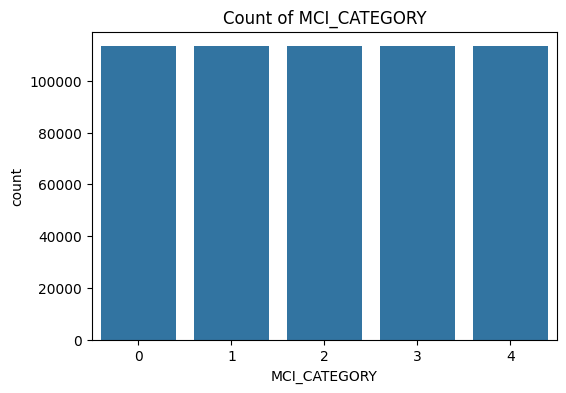

In [42]:
# Plotting for balanced target variable on train set
plt.figure(figsize=(6, 4))
sns.countplot(data=data_train, x='MCI_CATEGORY')
plt.title("Count of MCI_CATEGORY")
plt.show()

***1. Decision Tree Classifier***

In [43]:
## Training data
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier()

In [44]:
# Making predictions
y_pred_train_dt = dt_classifier.predict(X_train_resampled)
y_pred_test_dt = dt_classifier.predict(X_test)

In [45]:
# Evaluating the model
train_accuracy_dt = accuracy_score(y_train_resampled, y_pred_train_dt)
test_accuracy_dt = accuracy_score(y_test, y_pred_test_dt)

print("Training Accuracy:", train_accuracy_dt)
print("Test Accuracy:", test_accuracy_dt)

Training Accuracy: 1.0
Test Accuracy: 1.0


In [46]:
# Confusion metrics for Decision Tree classifier
cm_dt = metrics.confusion_matrix(y_test, y_pred_test_dt)
cm_dt

array([[48847,     0,     0,     0,     0],
       [    0, 15581,     0,     0,     0],
       [    0,     0, 20298,     0,     0],
       [    0,     0,     0,  7410,     0],
       [    0,     0,     0,     0,  3461]])

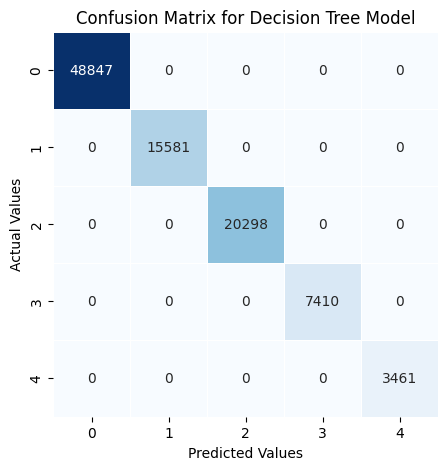

In [47]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_dt, annot=True, fmt='0.0f', linewidths=0.5,
            square=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix for Decision Tree Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [48]:
# Precision, Recall and F1 metrics for Decision Tree Classifier
print("Metrics for Decision Tree Algorithm:")
print(metrics.classification_report(y_test, y_pred_test_dt))

Metrics for Decision Tree Algorithm:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48847
           1       1.00      1.00      1.00     15581
           2       1.00      1.00      1.00     20298
           3       1.00      1.00      1.00      7410
           4       1.00      1.00      1.00      3461

    accuracy                           1.00     95597
   macro avg       1.00      1.00      1.00     95597
weighted avg       1.00      1.00      1.00     95597



***2. KNN Classifier***

In [49]:
## KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier()

In [50]:
# Making predictions
y_pred_train_knn = knn_classifier.predict(X_train_resampled)
y_pred_test_knn = knn_classifier.predict(X_test)

In [51]:
# Evaluating the model
train_accuracy_knn = accuracy_score(y_train_resampled, y_pred_train_knn)
test_accuracy_knn = accuracy_score(y_test, y_pred_test_knn)

print("Training Accuracy:", train_accuracy_knn)
print("Test Accuracy:", test_accuracy_knn)

Training Accuracy: 0.8909313985100449
Test Accuracy: 0.7351904348462818


In [52]:
# Confusion metrics for KNN classifier
cm_knn = metrics.confusion_matrix(y_test, y_pred_test_knn)
cm_knn

array([[42646,  1560,  2750,  1478,   413],
       [  897,  9863,  2864,   722,  1235],
       [ 1304,  2823, 12697,  2293,  1181],
       [  608,   594,  1935,  4038,   235],
       [  178,   908,  1110,   227,  1038]])

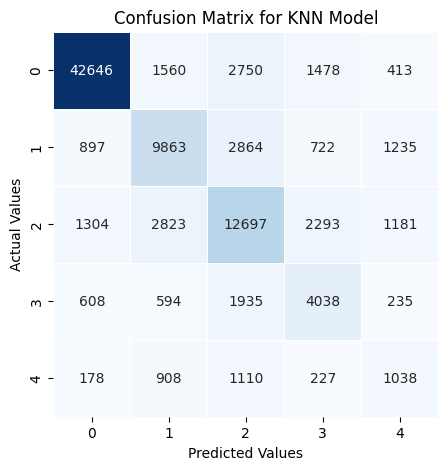

In [54]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_knn, annot=True, fmt='0.0f', linewidths=0.5,
            square=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix for KNN Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [55]:
# Precision, recall and F1 metrics for KNN classifier
print("Metrics for KNN Algorithm:")
print(metrics.classification_report(y_test, y_pred_test_knn))

Metrics for KNN Algorithm:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     48847
           1       0.63      0.63      0.63     15581
           2       0.59      0.63      0.61     20298
           3       0.46      0.54      0.50      7410
           4       0.25      0.30      0.27      3461

    accuracy                           0.74     95597
   macro avg       0.57      0.60      0.58     95597
weighted avg       0.75      0.74      0.74     95597



***3. Naive Bayes Classifier***

In [57]:
# Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_resampled, y_train_resampled)

GaussianNB()

In [58]:
# Making predictions
y_pred_train_nb = nb_classifier.predict(X_train_resampled)
y_pred_test_nb = nb_classifier.predict(X_test)

In [59]:
# Evaluating the model
train_accuracy_nb = accuracy_score(y_train_resampled, y_pred_train_nb)
test_accuracy_nb = accuracy_score(y_test, y_pred_test_nb)

print("Training Accuracy:", train_accuracy_nb)
print("Test Accuracy:", test_accuracy_nb)

Training Accuracy: 0.9945715496239805
Test Accuracy: 0.9908469931064783


In [60]:
# Confusion metrics for KNN classifier
cm_nb = metrics.confusion_matrix(y_test, y_pred_test_nb)
cm_nb

array([[48069,     0,     0,   778,     0],
       [    0, 15581,     0,     0,     0],
       [    0,     0, 20295,     0,     3],
       [    0,     0,     1,  7409,     0],
       [    0,    93,     0,     0,  3368]])

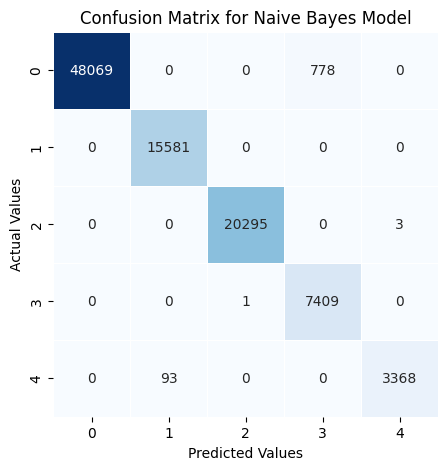

In [61]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_nb, annot=True, fmt='0.0f', linewidths=0.5,
            square=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix for Naive Bayes Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [62]:
# Precision, recall and F1 metrics for KNN classifier
print("Metrics for Naive Bayes Algorithm:")
print(metrics.classification_report(y_test, y_pred_test_nb))

Metrics for Naive Bayes Algorithm:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     48847
           1       0.99      1.00      1.00     15581
           2       1.00      1.00      1.00     20298
           3       0.90      1.00      0.95      7410
           4       1.00      0.97      0.99      3461

    accuracy                           0.99     95597
   macro avg       0.98      0.99      0.98     95597
weighted avg       0.99      0.99      0.99     95597



**4. Implementing Models Using Crossing Validation**

In [63]:
# Initializing classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
}

# Building Loop through each classifier
for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=10)

    clf.fit(X_train_resampled, y_train_resampled)

    test_score = clf.score(X_test, y_test)


    print(f"Classifier: {name}")
    print("Cross-validation scores on training set:", cv_scores)
    print("Mean cross-validation score on training set:", np.mean(cv_scores))
    print("Accuracy on test set:", test_score)
    print()

Classifier: Decision Tree
Cross-validation scores on training set: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean cross-validation score on training set: 1.0
Accuracy on test set: 1.0

Classifier: KNN
Cross-validation scores on training set: [0.75378668 0.79294213 0.80191011 0.81520319 0.83328037 0.83677577
 0.8359637  0.83504572 0.84030646 0.83532818]
Mean cross-validation score on training set: 0.8180542315432687
Accuracy on test set: 0.7351904348462818

Classifier: Naive Bayes
Cross-validation scores on training set: [0.99069661 0.99493345 0.99496875 0.9952159  0.99488049 0.9946863
 0.99533948 0.99459803 0.99482753 0.99484518]
Mean cross-validation score on training set: 0.9944991702856336
Accuracy on test set: 0.9908469931064783



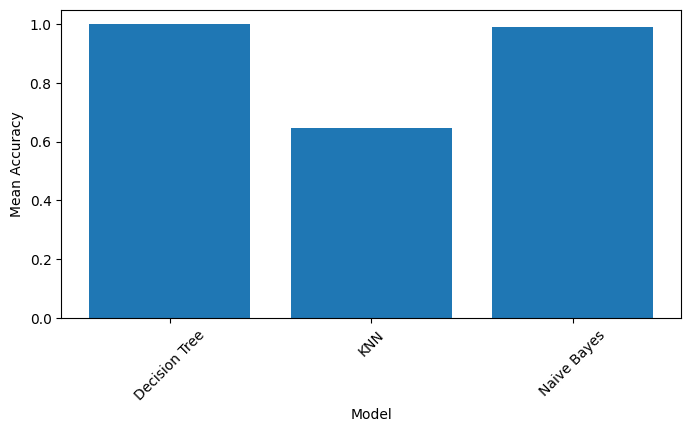

In [68]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

mean_accuracy = []

for name, model in models.items():
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    mean_accuracy.append(scores.mean())

# Plotting mean accuracy
plt.figure(figsize=(8, 4))
plt.bar(models.keys(), mean_accuracy, capsize=5)
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.xticks(rotation=45)
plt.show()

In [67]:
# Initializing classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)

    y_pred = clf.predict(X_test)

    report = classification_report(y_test, y_pred)

    print(f"Classifier: {name}")
    print(report)
    print()

Classifier: Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48847
           1       1.00      1.00      1.00     15581
           2       1.00      1.00      1.00     20298
           3       1.00      1.00      1.00      7410
           4       1.00      1.00      1.00      3461

    accuracy                           1.00     95597
   macro avg       1.00      1.00      1.00     95597
weighted avg       1.00      1.00      1.00     95597


Classifier: KNN
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     48847
           1       0.63      0.63      0.63     15581
           2       0.59      0.63      0.61     20298
           3       0.46      0.54      0.50      7410
           4       0.25      0.30      0.27      3461

    accuracy                           0.74     95597
   macro avg       0.57      0.60      0.58     95597
weighted avg       0.75      0.74 

**5. Splitting train and test sets from the beginning**

In [69]:
# Uploading AGAIN the selected dataset for this project
data = pd.read_csv('Major_Crime_Indicators_Open_Data.csv')

In [70]:
# Converting target variable to category type variable
data.MCI_CATEGORY = data.MCI_CATEGORY.astype('category')
# Removing duplicate rows from the dataset
data.drop_duplicates(subset = ['EVENT_UNIQUE_ID'], inplace = True)
# Omitting missing values
data.dropna(inplace=True)
# Dropping rows containing years of crime occurrence from 2000 to 2013
drop_rows = data['OCC_YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])
data.drop(data[drop_rows].index, inplace=True)
# Dropping NSA from HOOD_158 and NEIGHBOURHOOD_158
filtered_indices = data[(data['HOOD_158'] == 'NSA') | (data['NEIGHBOURHOOD_158'] == 'NSA')].index
data.drop(filtered_indices, inplace=True)

In [71]:
# Applying train-test_split
seed = 42
target_var = 'MCI_CATEGORY'
predictors = data.columns[data.columns != target_var]
X_train, X_test, y_train, y_test = train_test_split(data.loc[:,predictors], data[target_var], random_state = seed, test_size = 0.30)

In [72]:
# Cleaning dataset based on previous step DATA CLEANING AND PRE-PROCESSING & FEATURE SELECTION
def clean_data(data):
  attributes_to_drop = ['OBJECTID', 'EVENT_UNIQUE_ID', 'OFFENCE', 'LOCATION_TYPE', 'LAT_WGS84', 'LONG_WGS84', 'NEIGHBOURHOOD_140',
                        'HOOD_140', 'REPORT_HOUR', 'DIVISION', 'OCC_DATE', 'REPORT_DATE', 'REPORT_YEAR', 'REPORT_DOY', 'REPORT_DOW',
                        'OCC_DOW', 'OCC_DAY', 'REPORT_MONTH', 'OCC_DOY', 'OCC_MONTH', 'REPORT_DAY', 'UCR_EXT']
  data.drop(columns = attributes_to_drop, inplace = True)
  # Encoding categorical variables
  categorical_columns = ['UCR_CODE', 'PREMISES_TYPE', 'NEIGHBOURHOOD_158', 'HOOD_158', 'OCC_HOUR', 'OCC_YEAR']
  label_encoder = LabelEncoder()
  for column in categorical_columns:
      data[column] = label_encoder.fit_transform(data[column])
  return data

display(data)

,X,Y,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,...,UCR_CODE,UCR_EXT,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84
0,-8.809036e+06,5.431523e+06,1,GO-20141260264,2014/01/01 05:00:00+00,2014/01/01 05:00:00+00,2014,January,1,1,...,1430,100,Assault,Assault,143,West Rouge,131,Rouge (131),-79.132915,43.780413
2,-8.832825e+06,5.419631e+06,3,GO-20141259834,2014/01/01 05:00:00+00,2014/01/01 05:00:00+00,2014,January,1,1,...,1420,100,Assault With Weapon,Assault,55,Thorncliffe Park,55,Thorncliffe Park (55),-79.346615,43.703234
5,-8.840629e+06,5.412225e+06,6,GO-20141260618,2014/01/01 05:00:00+00,2014/01/01 05:00:00+00,2014,January,1,1,...,1430,100,Assault,Assault,81,Trinity-Bellwoods,81,Trinity-Bellwoods (81),-79.416718,43.655115
6,-8.839460e+06,5.423396e+06,7,GO-20141260730,2014/01/01 05:00:00+00,2014/01/01 05:00:00+00,2014,January,1,1,...,1430,100,Assault,Assault,105,Lawrence Park North,105,Lawrence Park North (105),-79.406223,43.727681
7,-8.813613e+06,5.428591e+06,8,GO-20141260831,2014/01/01 05:00:00+00,2014/01/01 05:00:00+00,2014,January,1,1,...,1430,100,Assault,Assault,136,West Hill,136,West Hill (136),-79.174031,43.761395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372893,-8.849874e+06,5.425325e+06,372894,GO-20232989815,2023/12/31 05:00:00+00,2023/12/31 05:00:00+00,2023,December,31,365,...,2120,210,Unlawfully In Dwelling-House,Break and Enter,25,Glenfield-Jane Heights,25,Glenfield-Jane Heights (25),-79.499768,43.740196
372894,-8.832825e+06,5.419631e+06,372895,GO-20232989838,2023/12/31 05:00:00+00,2023/12/31 05:00:00+00,2023,December,31,365,...,1430,100,Assault,Assault,55,Thorncliffe Park,55,Thorncliffe Park (55),-79.346615,43.703234
372895,-8.838191e+06,5.415297e+06,372896,GO-20232989777,2023/12/31 05:00:00+00,2023/12/31 05:00:00+00,2023,December,31,365,...,2120,200,B&E,Break and Enter,95,Annex,95,Annex (95),-79.394825,43.675083
372896,-8.851986e+06,5.429799e+06,372897,GO-20232990411,2023/12/31 05:00:00+00,2023/12/31 05:00:00+00,2023,December,31,365,...,1610,100,Robbery With Weapon,Robbery,24,Black Creek,24,Black Creek (24),-79.518742,43.769232


In [73]:
# Determining X_train and X_test
X_train = clean_data(X_train)
X_test = clean_data(X_test)

In [75]:
# Applying SMOTE to balance the train set
smote = SMOTE(random_state=123)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class Distribution after SMOTE:")
print(y_train_resampled.value_counts())

Class Distribution after SMOTE:
Assault            113573
Auto Theft         113573
Break and Enter    113573
Robbery            113573
Theft Over         113573
Name: MCI_CATEGORY, dtype: int64


In [76]:
# Initializing classifiers using 10-fold cross validation
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
}

for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=10)

    clf.fit(X_train_resampled, y_train_resampled)

    test_score = clf.score(X_test, y_test)

    print(f"Classifier: {name}")
    print("Cross-validation scores on training set:", cv_scores)
    print("Mean cross-validation score on training set:", np.mean(cv_scores))
    print("Accuracy on test set:", test_score)
    print()

Classifier: Decision Tree
Cross-validation scores on training set: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean cross-validation score on training set: 1.0
Accuracy on test set: 1.0

Classifier: KNN
Cross-validation scores on training set: [0.75446845 0.79042739 0.80490253 0.81111874 0.83538486 0.8375656
 0.83899201 0.83751277 0.83689642 0.83654422]
Mean cross-validation score on training set: 0.8183812976755354
Accuracy on test set: 0.7361318869839012

Classifier: Naive Bayes
Cross-validation scores on training set: [0.9908958  0.99468188 0.994541   0.99517495 0.99528061 0.99550946
 0.99480506 0.99492833 0.99528053 0.99427676]
Mean cross-validation score on training set: 0.9945374377940844
Accuracy on test set: 0.9899787650240071



**6. Revisiting Feature Selection**

In [86]:
# Uploading AGAIN the selected dataset for this project
data = pd.read_csv('Major_Crime_Indicators_Open_Data.csv')

In [87]:
# Converting target variable to categorical type variable
data.MCI_CATEGORY = data.MCI_CATEGORY.astype('category')
# Removing duplicate rows from the dataset
data.drop_duplicates(subset = ['EVENT_UNIQUE_ID'], inplace = True)
# Omitting missing values
data.dropna(inplace=True)
# Dropping rows containing years of crime occurrence from 2000 to 2013
drop_rows = data['OCC_YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])
data.drop(data[drop_rows].index, inplace=True)
# Dropping NSA from HOOD_158 and NEIGHBOURHOOD_158
filtered_indices = data[(data['HOOD_158'] == 'NSA') | (data['NEIGHBOURHOOD_158'] == 'NSA')].index
data.drop(filtered_indices, inplace=True)
# Dropping irrelevant variables to clean up the dataset
attributes_to_drop = ['OBJECTID', 'EVENT_UNIQUE_ID', 'REPORT_DATE', 'OCC_DATE']
data.drop(columns = attributes_to_drop, inplace = True)

In [88]:
# Encoding categorical variables
categorical_columns = ['UCR_CODE', 'PREMISES_TYPE', 'NEIGHBOURHOOD_158', 'HOOD_158', 'OCC_HOUR', 'OCC_YEAR', 'MCI_CATEGORY',
                       'OFFENCE', 'LOCATION_TYPE', 'LAT_WGS84', 'LONG_WGS84', 'NEIGHBOURHOOD_140', 'HOOD_140', 'REPORT_HOUR',
                       'DIVISION', 'REPORT_YEAR', 'REPORT_DOY', 'REPORT_DOW', 'OCC_DOW', 'OCC_DAY',
                       'REPORT_MONTH', 'OCC_DOY', 'OCC_MONTH', 'REPORT_DAY', 'UCR_EXT', 'X', 'Y']
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

In [89]:
# Applying train-test_split
seed = 42
target_var = 'MCI_CATEGORY'
predictors = data.columns[data.columns != target_var]
X_train, X_test, y_train, y_test = train_test_split(data.loc[:,predictors], data[target_var], random_state = seed, test_size = 0.30)

In [90]:
# Initializing SelectKBest with the f_classif scoring function
selector = SelectKBest(score_func=f_classif)
selector.fit(X_train, y_train)
k = 10
top_indices = selector.get_support(indices=True)
feature_names = X_train.columns

print("Top {} features:".format(k))
for i in top_indices:
    print(feature_names[i])

Top 10 features:
X
REPORT_YEAR
OCC_YEAR
OCC_HOUR
LOCATION_TYPE
PREMISES_TYPE
UCR_CODE
UCR_EXT
OFFENCE
HOOD_140


In [91]:
# Dropping variables except for the ones selected
columns_to_drop = ['Y', 'LAT_WGS84', 'LONG_WGS84', 'NEIGHBOURHOOD_140','REPORT_HOUR','DIVISION', 'REPORT_DOY',
                   'REPORT_DOW', 'OCC_DOW', 'OCC_DAY', 'REPORT_MONTH', 'OCC_DOY', 'OCC_MONTH', 'REPORT_DAY',
                   'NEIGHBOURHOOD_158', 'HOOD_158']
X_train.drop(columns = columns_to_drop, inplace = True)
X_test.drop(columns = columns_to_drop, inplace = True)
display(X_train)

,X,REPORT_YEAR,OCC_YEAR,OCC_HOUR,LOCATION_TYPE,PREMISES_TYPE,UCR_CODE,UCR_EXT,OFFENCE,HOOD_140
220976,13473,6,6,18,22,1,1,0,11,79
12416,14635,0,0,17,0,0,2,0,5,99
212961,18370,6,6,22,22,1,13,0,36,41
113399,6078,3,3,9,0,0,2,0,5,65
29658,11670,0,0,5,0,0,2,0,5,109
...,...,...,...,...,...,...,...,...,...,...
141037,9109,4,4,13,22,1,20,10,45,2
304048,6753,8,8,14,21,5,2,0,5,69
155177,10034,4,4,11,22,1,15,10,12,117
172596,6641,5,5,23,22,1,2,0,5,132


In [92]:
# Applying SMOTE to balance the train set
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class Distribution after SMOTE:")
print(y_train_resampled.value_counts())

Class Distribution after SMOTE:
0    113573
3    113573
1    113573
2    113573
4    113573
Name: MCI_CATEGORY, dtype: int64


In [93]:
# Initialize classifiers using 10-fold cross validation
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
}

for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=10)

    clf.fit(X_train_resampled, y_train_resampled)

    test_score = clf.score(X_test, y_test)

    print(f"Classifier: {name}")
    print("Cross-validation scores on training set:", cv_scores)
    print("Mean cross-validation score on training set:", np.mean(cv_scores))
    print("Accuracy on test set:", test_score)
    print()

Classifier: Decision Tree
Cross-validation scores on training set: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean cross-validation score on training set: 1.0
Accuracy on test set: 1.0

Classifier: KNN
Cross-validation scores on training set: [0.97224717 0.97152517 0.97347985 0.9788684  0.98311233 0.98307681
 0.98240764 0.98226676 0.98228437 0.98321769]
Mean cross-validation score on training set: 0.9792486189678389
Accuracy on test set: 0.9360230969591096

Classifier: Naive Bayes
Cross-validation scores on training set: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean cross-validation score on training set: 1.0
Accuracy on test set: 1.0

